# Processing and set up

## compile data (features and labels)

In [ ]:
import os
import pandas as pd
import numpy as np
import nibabel as nib
from itertools import combinations
from scipy.signal import butter, filtfilt
from glob import glob

# thresholds and range for motion
threshold = 0.09 # filtered FD threshold
notch_low = 18/60 # breaths per second, lower range
notch_high = 30/60 # breaths per second, higher range

# set up file paths
proj_home = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/MoviesVsRest'
data_dir = os.path.join(proj_home, 'DATA','cens09filtFD')

# load sample information
sample_info = pd.read_csv(os.path.join(proj_home, 'sample_information','HBN_MRI_DATA_TRACKER_20220102.csv'), 
                          index_col=0, na_values='n')
sample_info = sample_info.loc[sample_info[['movieDM','movieTP','rest_run-1','rest_run-2']].sum(axis=1)>=1,
                              ['release_number','Sex','Age','EHQ_Total','site']]
sample_info.index = ['sub-{0}'.format(s) for s in sample_info.index]
sample_info.index.name = 'sub'
sample_info.head()

In [ ]:
data_labels = pd.DataFrame()
pconns = []
idx = 0

for s in sample_info.index:
    for context in ['movie','rest']:
        ts = os.path.join(data_dir, 'ptseries', '{0}_{1}_gordon.32k_fs_LR.ptseries.nii'.format(s, context))
        conn = os.path.join(data_dir, 'pconns', '{0}_{1}_gordon.32k_fs_LR.pconn.nii'.format(s, context))
        if os.path.isfile(ts):
            temp = nib.load(conn).get_fdata()[:333,:333]
            pconns.append(np.expand_dims(temp, axis=2))
            TR = nib.load(ts).header.get_axis(0).step
            dur = nib.load(ts).header.get_axis(0).size
            fs = 1/TR

            data_labels.loc[idx, 'sub'] = s
            data_labels.loc[idx, 'context'] = context
            data_labels.loc[idx, 'seconds_usable'] = dur*TR
            
            mot = glob(os.path.join(data_dir, 'motion', 
                                    '{0}_task-{1}*_bold1_AP_Movement_Regressors_dt.txt'.format(s, context)))
            mot_data = []
            for m in mot:
                motion = np.loadtxt(m)[:,6:]
                motion[:,3:] = 50*(np.pi/180)*motion[:,3:]
                notchb, notcha = butter(2, [notch_low, notch_high], 'bandstop', fs=fs)
                motion = filtfilt(notchb, notcha, motion, axis=0)
                mot_data.append(motion)

            if len(mot_data)>1:
                motion = np.concatenate(mot_data, axis=0)
            else:
                motion = mot_data[0]

            # identify volumes to censor
            fd = np.sum(np.absolute(motion),axis=1)
            vols_to_censor = fd>threshold
            fd_cens = fd[vols_to_censor==0] 

            # add motion metrics to spreadsheet
            data_labels.loc[idx, 'rawFD'] = np.mean(fd)
            data_labels.loc[idx, 'censFD'] = np.mean(fd_cens)
            data_labels.loc[idx, 'Nvolscens'] = np.sum(vols_to_censor)

            idx += 1      

In [ ]:
# load cognitive scores
cog = pd.read_csv(os.path.join(proj_home, 'cog_EFA','Cog_EFA_factorscores.csv'), index_col=0)
cog.index = ['sub-{0}'.format(s) for s in cog.index]
cog.index.name = 'sub'

data_labels.index = data_labels['sub']
data_labels = data_labels.merge(sample_info, how="left", left_index=True, right_index=True)
data_labels = data_labels.merge(cog, how="left", left_index=True, right_index=True)
data_labels.to_csv(os.path.join(data_dir, 'data_labels.csv'))
data_labels.head()

In [ ]:
# save 3D connectivity data
group_pconns = np.concatenate(pconns, axis=2)
print(group_pconns.shape)
np.save(os.path.join(data_dir, 'pconn_data_3d.npy'), group_pconns)

In [ ]:
# flatten and save data
conn = os.path.join(data_dir, 'pconns', '{0}_movie_gordon.32k_fs_LR.pconn.nii'.format(s))
labels = nib.load(conn).header.get_axis(1).name[:-19]
combs = combinations(labels,2)
flat_data = pd.DataFrame(index = data_labels.index)

for c in combs:
    labA = c[0]
    locA = np.where(labels==labA)[0][0]
    labB = c[1]
    locB = np.where(labels==labB)[0][0]
    flat_data.loc[:, '{0}-{1}'.format(labA, labB)] = group_pconns[locA, locB, :]

flat_data.to_csv(os.path.join(data_dir, 'pconn_data_2d.csv'))
np.save(os.path.join(data_dir, 'pconn_data_2d.npy'), flat_data.to_numpy())
flat_data.head()

# Are cognitive scores associated with age, sex, or motion?

In [ ]:
import os
import pandas as pd
import numpy as np
import scipy.stats as scp
import seaborn as sns
sns.set(context='talk', style='white')

# set up file paths
proj_home = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/MoviesVsRest'
data_dir = os.path.join(proj_home, 'DATA','cens09filtFD')

# load data
data_labels = pd.read_csv(os.path.join(data_dir, 'data_labels.csv'), index_col=0)

In [ ]:
for context in ['movie','rest']:
    temp = data_labels.loc[(data_labels['context']==context) & (np.isfinite(data_labels['Cog1'])), :]
    
    print('------------------ {0} ----------------'.format(context))
    for cov in ['rawFD','censFD','Nvolscens','Age']:
        # correlations
        r, p = scp.spearmanr(temp[cov], temp['Cog1'], nan_policy='omit')
        print('Cog1 and {0}: r={1}, p={2}.'.format(cov, round(r,2), round(p,3)))
        sns.lmplot(x='Cog1', y=cov, data=temp, ci=None, line_kws={'color':'k', 'lw':4}, 
                   scatter_kws={'color':'gray', 'alpha':0.3})
        plt.show()
        plt.close()
    
    # Sex differences
    t, p = scp.ttest_ind(temp.loc[temp['Sex']==1, 'Cog1'], temp.loc[temp['Sex']==0, 'Cog1'], nan_policy='omit')
    print('Cog1 and Sex: t={1}, p={2}.'.format(cov, round(t,2), round(p,3)))
    sns.boxplot(x='Sex', y='Cog1', data=temp)
    sns.stripplot(x='Sex', y='Cog1', data=temp,
                  size=4, color='k', alpha=0.4, linewidth=0)
    sns.despine()
    plt.show()
    plt.close()

# Analysis: Can we predict cognitive scores from connectivity values?

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from SVR_functions import cv_fit, predict_out, make_consistency_plot, boot_predict, permuted_p, permuted_importance
sns.set(context='paper', style='white')

# set up file paths
proj_home = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/MoviesVsRest'
data_dir = os.path.join(proj_home, 'DATA','cens09filtFD')
results_dir = os.path.join(proj_home, 'RESULTS','cens09filtFD')
os.makedirs(results_dir, exist_ok=True)

# load data
data = np.load(os.path.join(data_dir, 'pconn_data_2d.npy'))
data_labels = pd.read_csv(os.path.join(data_dir, 'data_labels.csv'), index_col=0)
edge_labels = pd.read_csv(os.path.join(data_dir, 'pconn_data_2d.csv'), index_col=0).columns.to_list()

# limit data to participants with at least 300s of data
data = data[data_labels['seconds_usable']>=300]
data_labels = data_labels.loc[data_labels['seconds_usable']>=300,:]
data_labels.describe()

,seconds_usable,rawFD,censFD,Nvolscens,Sex,Age,EHQ_Total,Cog1,Cog2
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1026.000000,944.000000,944.000000
mean,474.903502,0.117349,0.050860,296.934825,0.393969,10.819344,61.775361,5.388676,1.708382
std,119.107562,0.069236,0.006995,159.008738,0.488866,2.713989,49.569358,1.995708,0.334919
min,300.000000,0.023551,0.021643,7.000000,0.000000,5.061259,-100.000000,0.861285,0.877491
25%,376.600000,0.072819,0.046675,176.750000,0.000000,8.630817,50.285000,3.891126,1.467506
50%,459.200000,0.098973,0.051845,283.000000,0.000000,10.703684,80.040000,5.486198,1.691122
75%,552.800000,0.139418,0.055775,402.000000,1.000000,13.088523,96.402500,7.014392,1.940749
max,789.600000,0.559902,0.065634,625.000000,1.000000,15.987451,100.050000,9.183065,3.005091


movie train sample N=439, test sample N=110


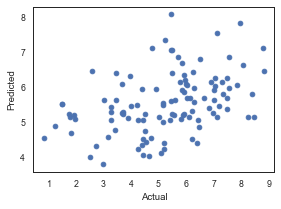

rest train sample N=316, test sample N=79


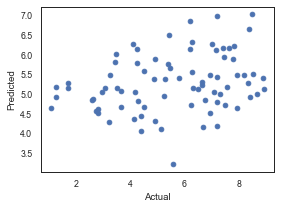

In [2]:
# loop over movie/rest
for context in ['movie','rest']:
    out_folder = os.path.join(results_dir, 'min300s', 'Cog1', context)
    os.makedirs(out_folder, exist_ok=True)
    model = SVR(kernel='linear')
    cv = 10
    
    # split data to train/test
    X = data[(data_labels['context']==context) & (np.isfinite(data_labels['Cog1']))]
    Y = data_labels.loc[(data_labels['context']==context) & (np.isfinite(data_labels['Cog1'])), 'Cog1'].to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    print('{0} train sample N={1}, test sample N={2}'.format(context, len(Y_train), len(Y_test)))
    
    # train model
    estimators, weights, mean_weights, Y_pred_train, train_scores = cv_fit(model, X_train, Y_train, cv)
    
    # test model
    Y_pred_test, accuracy = predict_out(X_test, Y_test, estimators, 'regress')
    accuracy.to_csv(os.path.join(out_folder,'test_accuracy.csv'))
    if not os.path.isfile(os.path.join(out_folder, 'bootstrapped_test_accuracy_randN.csv')):
        boot_predict(estimators, X_test, Y_test, out_folder, samples=1000)
    if not os.path.isfile(os.path.join(out_folder, 'permutation_score_distribution.npy')):
        results = permuted_p(model, X_train, Y_train, cv, out_folder, np.mean(train_scores), -accuracy.loc['MSE','stat'])
    #permuted_importance(estimators, X_train, Y_train, edge_labels, out_folder)
    
    # plot results
    plot_file_name = os.path.join(out_folder, 'testing_data_consistency.svg')
    make_consistency_plot(Y_test, Y_pred_test, cv, plot_file_name)

# Analysis: can we predict ADHD symptoms from connectivity values?

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scp
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from SVR_functions import cv_fit, predict_out, make_consistency_plot, boot_predict, permuted_p, permuted_importance
sns.set(context='paper', style='white')

# set up file paths
proj_home = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/MoviesVsRest'
data_dir = os.path.join(proj_home, 'DATA','cens09filtFD')
results_dir = os.path.join(proj_home, 'RESULTS','cens09filtFD')
os.makedirs(results_dir, exist_ok=True)

# load data
data = np.load(os.path.join(data_dir, 'pconn_data_2d.npy'))
data_labels = pd.read_csv(os.path.join(data_dir, 'data_labels.csv'), index_col=0)
edge_labels = pd.read_csv(os.path.join(data_dir, 'pconn_data_2d.csv'), index_col=0).columns.to_list()

# limit data to participants with at least 300s of data
data = data[data_labels['seconds_usable']>=300]
data_labels = data_labels.loc[data_labels['seconds_usable']>=300,:]

# add ADHD scores to the data labels
adhd_info = pd.read_excel(os.path.join(proj_home, 'ADHD','MovieVSRest.xlsx'), 
                        index_col='EID').loc[:,['SWAN_HY_Avg', 'SWAN_IN_Avg', 'C3SR_HY_T', 'C3SR_IN_T']]
adhd_info.index = ['sub-{0}'.format(s) for s in adhd_info.index]
adhd_info.index.name = 'sub'

data_labels = data_labels.merge(adhd_info, how='left', left_index=True, right_index=True)
data_labels.describe()

,seconds_usable,rawFD,censFD,Nvolscens,Sex,Age,EHQ_Total,Cog1,Cog2,SWAN_HY_Avg,SWAN_IN_Avg,C3SR_HY_T,C3SR_IN_T
count,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1028.000000,1026.000000,944.000000,944.000000,918.000000,918.000000,786.000000,786.000000
mean,474.903502,0.117349,0.050860,296.934825,0.393969,10.819344,61.775361,5.388676,1.708382,0.165456,0.611353,59.454198,63.956743
std,119.107562,0.069236,0.006995,159.008738,0.488866,2.713989,49.569358,1.995708,0.334919,1.079144,1.152118,12.673904,14.447909
min,300.000000,0.023551,0.021643,7.000000,0.000000,5.061259,-100.000000,0.861285,0.877491,-3.000000,-3.000000,40.000000,40.000000
25%,376.600000,0.072819,0.046675,176.750000,0.000000,8.630817,50.285000,3.891126,1.467506,-0.222222,0.000000,50.000000,52.000000
50%,459.200000,0.098973,0.051845,283.000000,0.000000,10.703684,80.040000,5.486198,1.691122,0.222222,0.666666,58.000000,62.000000
75%,552.800000,0.139418,0.055775,402.000000,1.000000,13.088523,96.402500,7.014392,1.940749,0.777777,1.444444,68.000000,76.000000
max,789.600000,0.559902,0.065634,625.000000,1.000000,15.987451,100.050000,9.183065,3.005091,3.000000,3.000000,90.000000,90.000000


SWAN_HY_Avg movie train sample N=428, test sample N=107


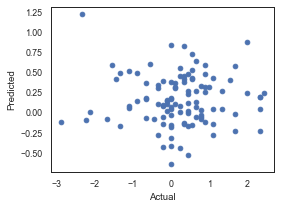

SWAN_HY_Avg rest train sample N=306, test sample N=77


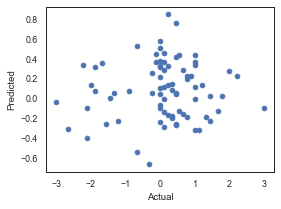

SWAN_IN_Avg movie train sample N=428, test sample N=107


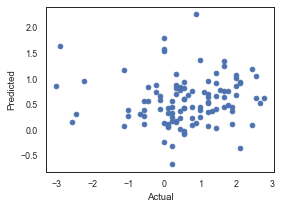

SWAN_IN_Avg rest train sample N=306, test sample N=77


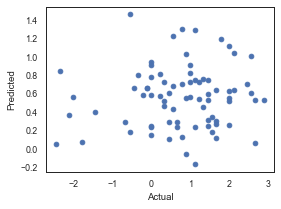

C3SR_HY_T movie train sample N=352, test sample N=88


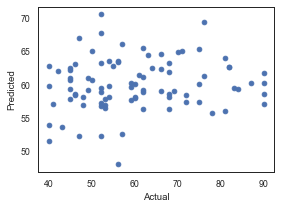

C3SR_HY_T rest train sample N=276, test sample N=70


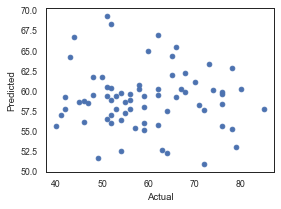

C3SR_IN_T movie train sample N=352, test sample N=88


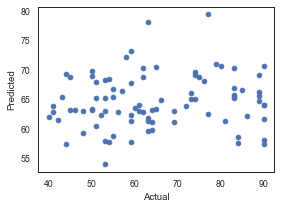

C3SR_IN_T rest train sample N=276, test sample N=70


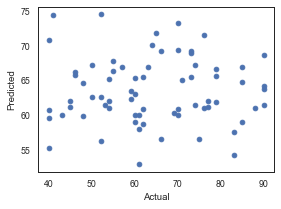

In [4]:
for adhd in ['SWAN_HY_Avg', 'SWAN_IN_Avg', 'C3SR_HY_T', 'C3SR_IN_T']:
    # loop over movie/rest
    for context in ['movie','rest']:
        out_folder = os.path.join(results_dir, 'min300s', adhd, context)
        os.makedirs(out_folder, exist_ok=True)
        model = SVR(kernel='linear')
        cv = 10

        # split data to train/test
        X = data[(data_labels['context']==context) & (np.isfinite(data_labels[adhd]))]
        Y = data_labels.loc[(data_labels['context']==context) & (np.isfinite(data_labels[adhd])), adhd].to_numpy()
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
        print('{0} {1} train sample N={2}, test sample N={3}'.format(adhd, context, len(Y_train), len(Y_test)))

        # train model
        estimators, weights, mean_weights, Y_pred_train, train_scores = cv_fit(model, X_train, Y_train, cv)

        # test model
        Y_pred_test, accuracy = predict_out(X_test, Y_test, estimators, 'regress')
        accuracy.to_csv(os.path.join(out_folder,'test_accuracy.csv'))
        if not os.path.isfile(os.path.join(out_folder, 'bootstrapped_test_accuracy_randN.csv')):
            boot_predict(estimators, X_test, Y_test, out_folder, samples=1000)
        if not os.path.isfile(os.path.join(out_folder, 'permutation_score_distribution.npy')):
            results = permuted_p(model, X_train, Y_train, cv, out_folder, np.mean(train_scores), -accuracy.loc['MSE','stat'])
        #permuted_importance(estimators, X_train, Y_train, edge_labels, out_folder)

        # plot results
        plot_file_name = os.path.join(out_folder, 'testing_data_consistency.svg')
        make_consistency_plot(Y_test, Y_pred_test, cv, plot_file_name)